In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, set_matplotlib_formats
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
# Run once
#!pip install -Uq pystan==2.19.1.1 prophet
!pip install -Uq statsmodels

In [47]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import investpy
from datetime import date, datetime
from pathlib import Path
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass, field
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

In [12]:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
pd.set_option('display.max_rows', 500)

In [15]:
COUNTRY = "malaysia"                   
DATASET_FOLDER = "test_data"
TARGET_DATASET_FOLDER = f"{DATASET_FOLDER}/{COUNTRY}"
STOCKS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks.csv"
STOCKS_INFO_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_info.csv"
STOCKS_FINANCE_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_finance.csv"
STOCKS_DIVIDENDS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_dividends.csv"
STOCKS_SELECTED = f"{TARGET_DATASET_FOLDER}/stocks_selected.csv"
STOCKS_HISTORICAL_PRICES = f"{TARGET_DATASET_FOLDER}/stocks_historcal_prices.csv"

FROM_DATE = '1/1/2015'
TO_DATE = datetime.strftime(date.today(), '%d/%m/%Y')

In [16]:
def save_csv(df, file_name, index=True):
    df.to_csv(file_name, header=True, index=index)

In [17]:
df_stocks_selected = pd.read_csv(STOCKS_SELECTED)
display(df_stocks_selected.head(10))

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE,Symbol,Yield
0,MBBM,8.170,8.16-8.32,22890000000.0,8.170,6.96-9.01,0.60,11938400.0,95530000000.0,0.52(6.50%),6173324.0,13.53,1.07,8.21%,1.169334e+10,26/08/2021,13.53,MBBM,10.310
1,BSTB,2.000,1.99-2.04,4830000000.0,2.000,1.88-2.27,0.14,811000.0,2680000000.0,0.12(6.16%),577756.0,14.73,0.08,-4.27%,1.341900e+09,16/11/2021,14.73,BSTB,14.250
2,BMYS,7.330,7.35-7.53,878.24M,7.350,7.31-9.9,0.54,3397500.0,5930000000.0,0.50(6.61%),1280013.0,13.57,1.21,-26.26%,8.092991e+08,02/11/2021,13.57,BMYS,8.620
3,BATO,14.000,13.96-14.1,2450000000.0,13.980,9.8-16.2,0.95,178200.0,359310000000.0,0.93(6.60%),316373.0,14.74,0.49,35.92%,2.288578e+09,24/08/2021,14.74,BATO,31.240
4,UOAD,1.590,1.58-1.62,609.5M,1.600,1.46-1.92,0.15,1813800.0,3700000000.0,0.14(8.86%),558834.0,10.75,0.78,-4.22%,2.326466e+09,31/08/2021,10.75,UOAD,8.320
5,TPGC,3.760,3.74-3.85,17400000000.0,3.770,3.64-9.72,1.05,7641600.0,30110000000.0,0.59(15.72%),19801147.0,3.58,0.78,-59.7%,8.006863e+09,17/09/2021,3.58,TPGC,17.435
6,ASTR,1.090,1.08-1.11,4370000000.0,1.090,0.71-1.26,0.12,3623600.0,5680000000.0,0.09(7.87%),5383905.0,9.37,1.32,42.48%,5.214507e+09,16/09/2021,9.37,ASTR,21.245
7,KRIB,3.060,3.04-3.17,6760000000.0,3.070,2.93-8.39,1.17,3109300.0,7810000000.0,0.24(7.64%),5491692.0,2.61,1.42,-62.68%,2.551620e+09,08/11/2021,2.61,KRIB,8.055
8,BERA,1.580,1.57-1.63,2290000000.0,1.590,1.12-1.64,0.12,4542600.0,1840000000.0,0.05(3.17%),1953342.0,13.74,1.35,14.49%,1.161428e+09,16/09/2021,13.74,BERA,12.810
9,DOMN,0.815,0.825-0.87,601.04M,0.825,0.655-1.2,0.09,589800.0,134.67M,0.03(4.29%),84497.0,8.98,0.49,18.12%,1.652402e+08,30/08/2021,8.98,DOMN,10.835


In [18]:
def get_stock_historical_prices(symbol, country):
    try:
        return investpy.get_stock_historical_data(symbol, country, FROM_DATE, TO_DATE)
    except:
        return None
    
def download_historical_prices(df):
    df_history = None
    count = 0
    for _, row in df.iterrows():
        count = count + 1
        print(f"{count}/{len(df)}: {row.Symbol}")
        df_stock = get_stock_historical_prices(row.Symbol, COUNTRY)
        if df_stock is None:
            continue
        df_stock['Symbol'] = row.Symbol
        if df_history is None:
            df_history  = df_stock
        else:
            df_history = df_history.append(df_stock)
        if count % 10 == 0:
            save_csv(df_history, STOCKS_HISTORICAL_PRICES)
            time.sleep(3)
    save_csv(df_history, STOCKS_HISTORICAL_PRICES)

In [19]:
#download_historical_prices(df_stocks_selected)

## Forecast Changes

In [20]:
df_history = pd.read_csv(STOCKS_HISTORICAL_PRICES, parse_dates=['Date'])
display(df_history.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47491 entries, 0 to 47490
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      47491 non-null  datetime64[ns]
 1   Open      47491 non-null  float64       
 2   High      47491 non-null  float64       
 3   Low       47491 non-null  float64       
 4   Close     47491 non-null  float64       
 5   Volume    47491 non-null  int64         
 6   Currency  47491 non-null  object        
 7   Symbol    47491 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 2.9+ MB


None

<AxesSubplot:>

,Close
Date,
2015-01-02,9.12
2015-01-05,9.00
2015-01-06,8.80
2015-01-07,8.61
2015-01-08,8.70
2015-01-09,8.61
2015-01-12,8.58
2015-01-13,8.62
2015-01-14,8.39


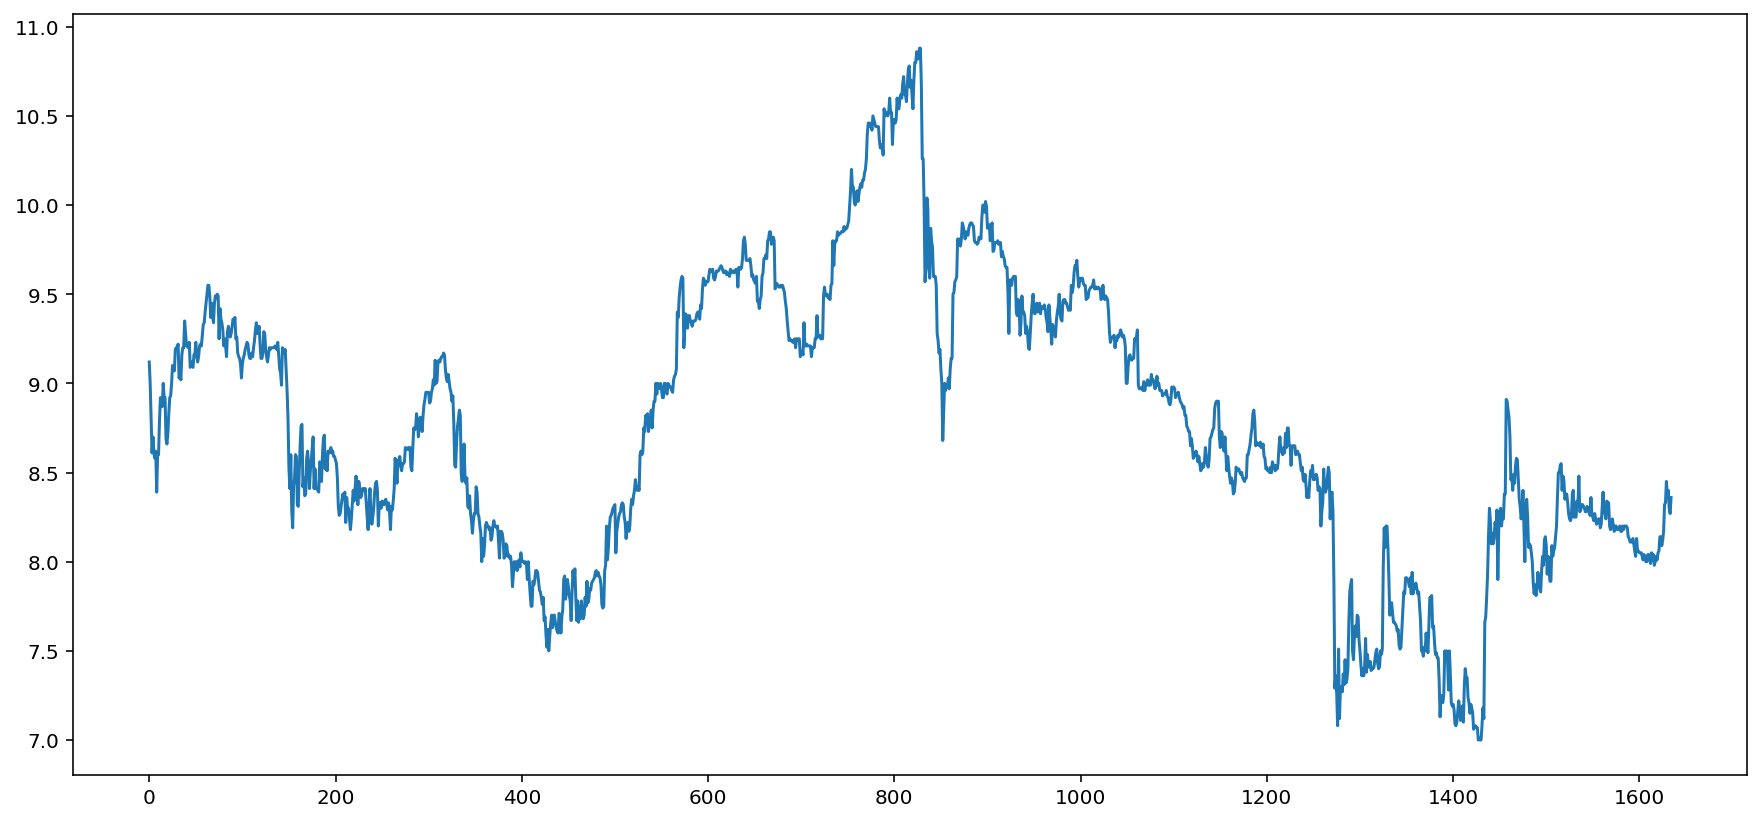

In [40]:
# Try with 1 stock
df_stock = df_history[df_history['Symbol'] == 'MBBM'].copy()
df_stock['Close'].plot(figsize = (15,7))

df_stock.set_index('Date', inplace=True)
df_stock.sort_values('Date', inplace=True)

df_stock.drop(columns=['Open', 'High', 'Volume', 'Currency', 'Symbol', 'Low'], inplace=True)
df_stock.head(10)

In [45]:
# Aggregate weekly
df_week = df_stock.resample('w').mean()
df_week = df_week[['Close']]
df_week.head(10)

,Close
Date,
2015-01-04,9.120000
2015-01-11,8.744000
2015-01-18,8.558000
2015-01-25,8.890000
2015-02-01,8.782000
2015-02-08,8.893333
2015-02-15,9.092000
2015-02-22,9.206667
2015-03-01,9.092000


In [49]:
# Take the log to of the returns to normalize large fluctuations.
df_week['weekly_ret'] = np.log(df_week['Close']).diff()
df_week.head(10)

,Close,weekly_ret
Date,,
2015-01-04,9.120000,NaN
2015-01-11,8.744000,-0.042102
2015-01-18,8.558000,-0.021501
2015-01-25,8.890000,0.038061
2015-02-01,8.782000,-0.012223
2015-02-08,8.893333,0.012598
2015-02-15,9.092000,0.022093
2015-02-22,9.206667,0.012533
2015-03-01,9.092000,-0.012533


In [50]:
# drop null rows
df_week.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

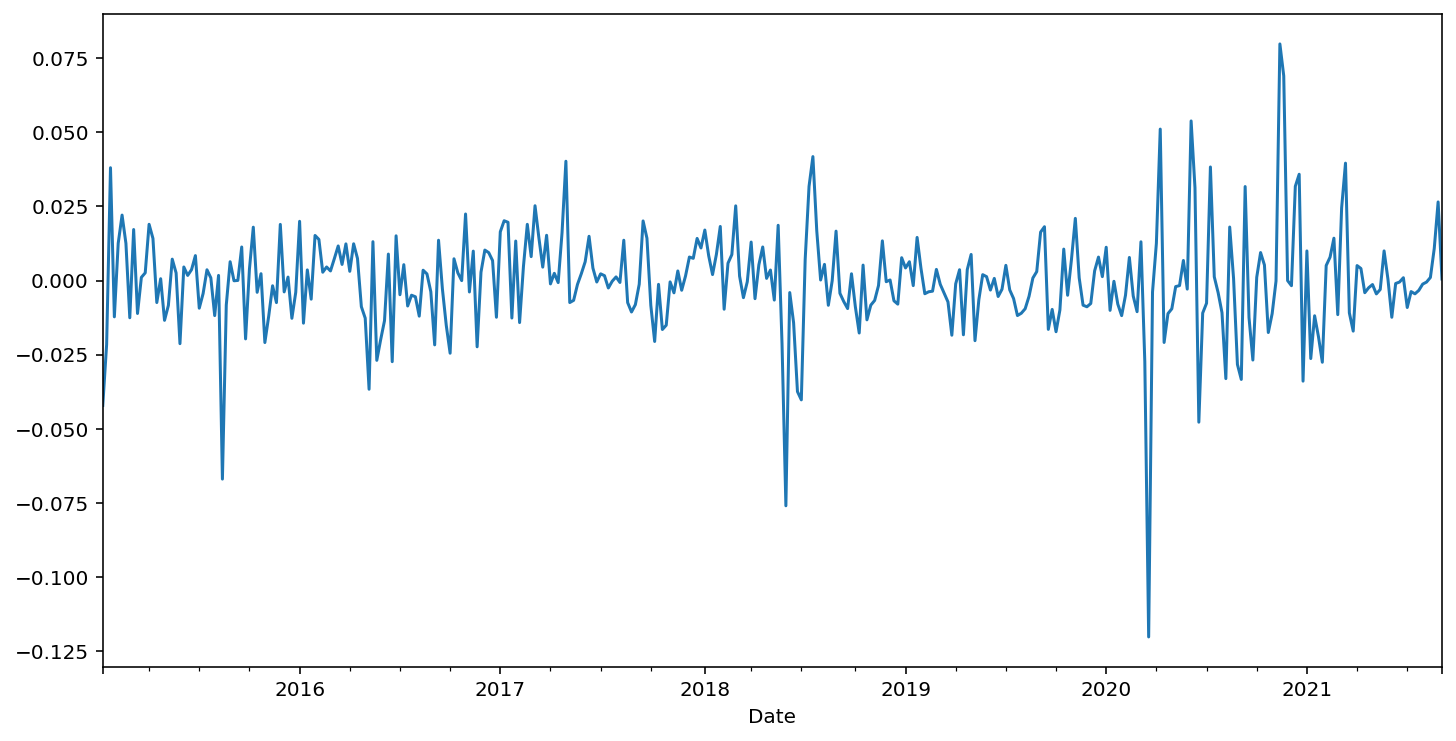

In [51]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6))

In [54]:
udiff = df_week.drop(['Close'], axis=1)
udiff.head()

,weekly_ret
Date,
2015-01-11,-0.042102
2015-01-18,-0.021501
2015-01-25,0.038061
2015-02-01,-0.012223
2015-02-08,0.012598


<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

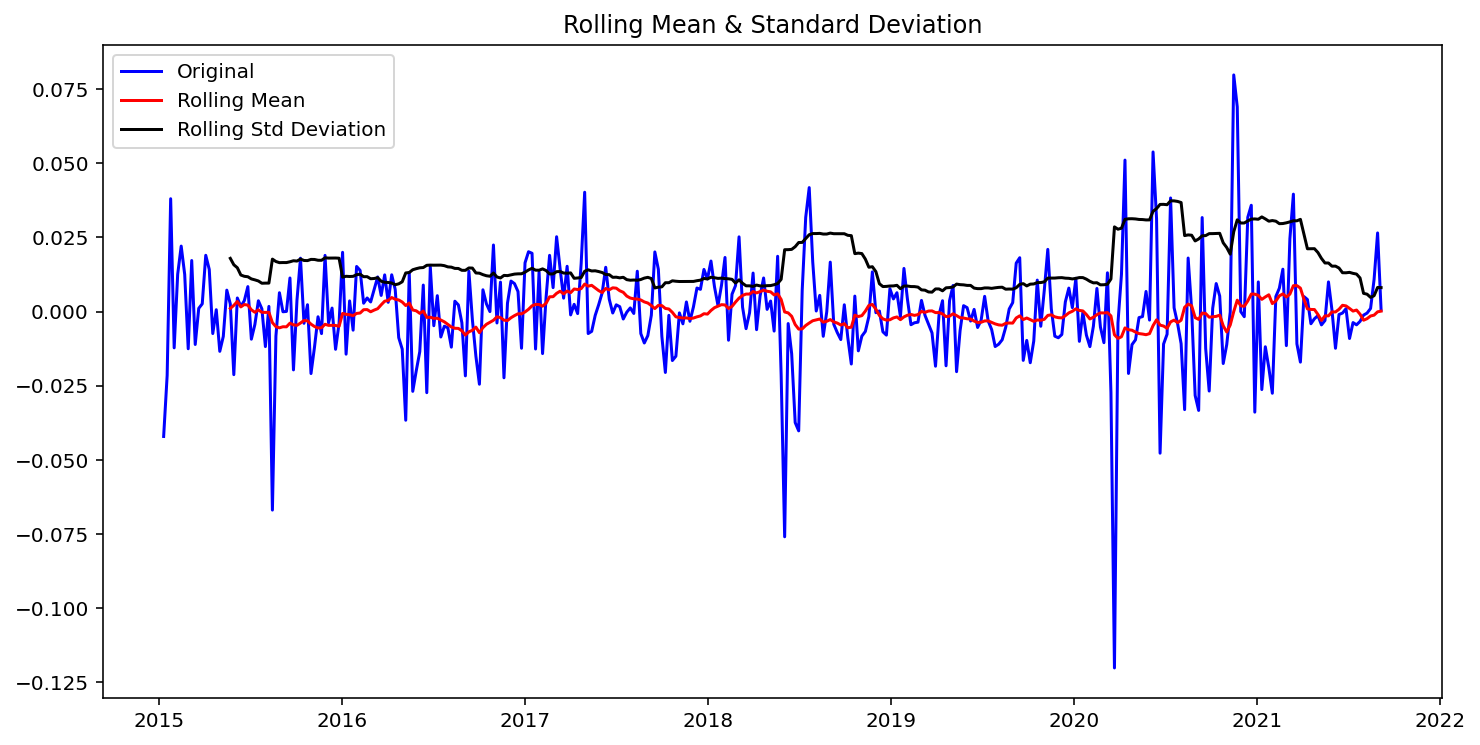

In [55]:
# Stationarity test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [58]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value

# p < 0.05 reject null hypothesis. Data is stationary
dfoutput

Test Statistic                -1.354304e+01
p-value                        2.491861e-25
#Lags Used                     1.000000e+00
Number of Observations Used    3.460000e+02
Critical Value (1%)           -3.449392e+00
Critical Value (5%)           -2.869930e+00
Critical Value (10%)          -2.571240e+00
dtype: float64

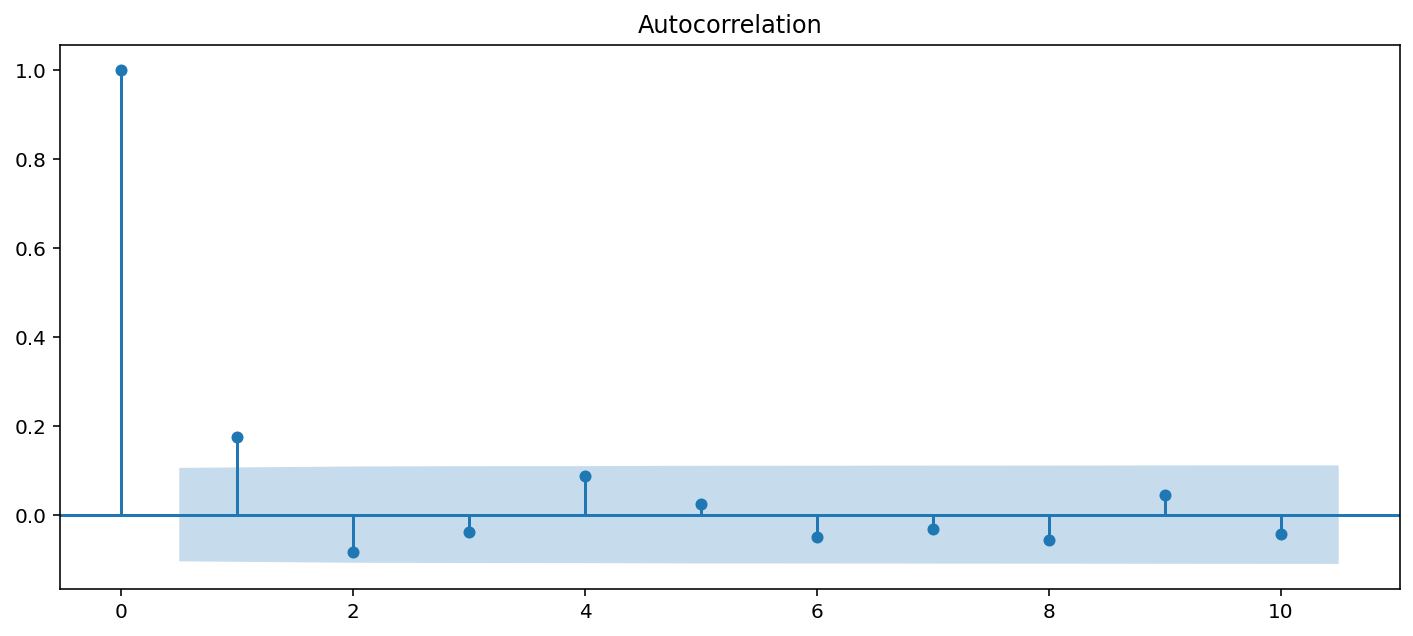

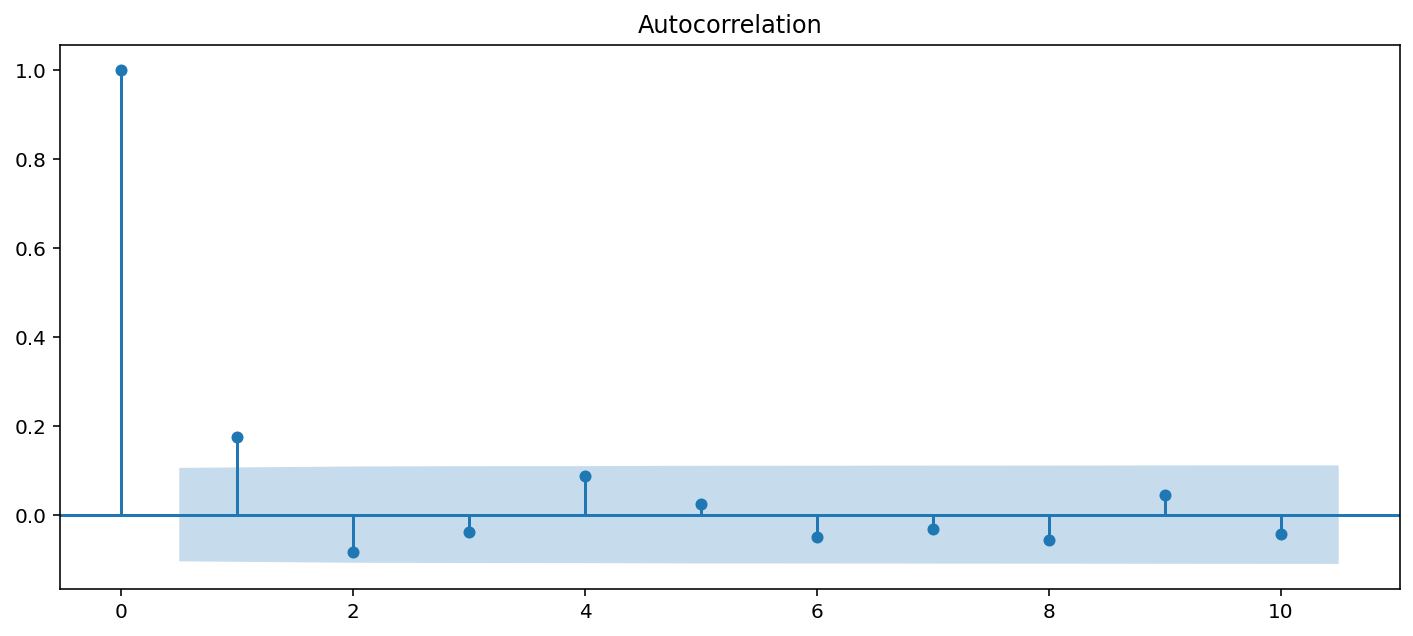

In [63]:
# ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

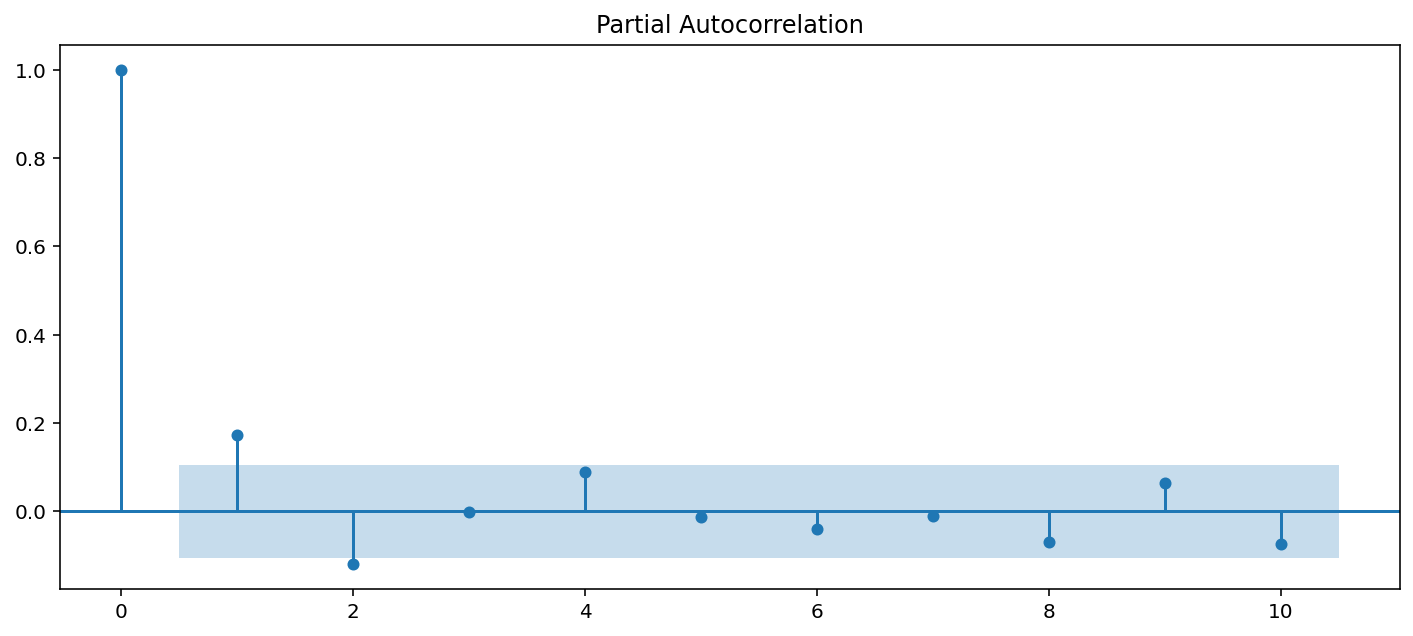

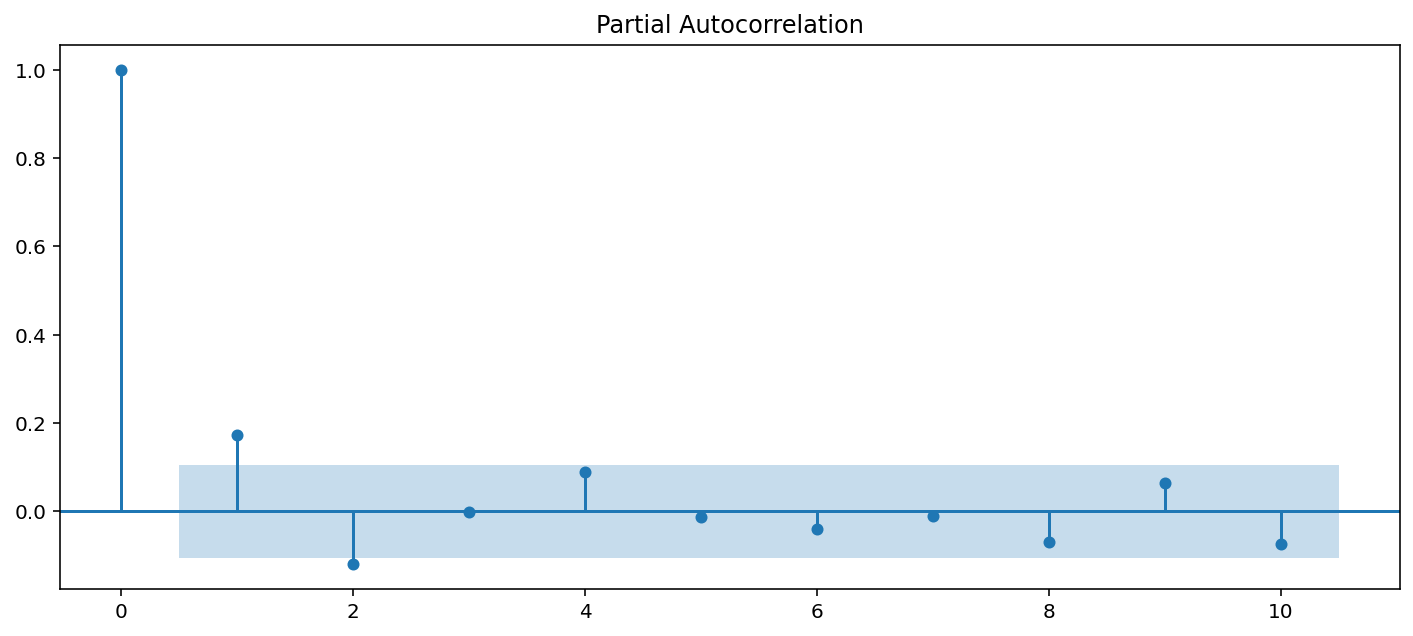

In [65]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

In [78]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data rather than the original data. 
ar1 = ARIMA(tuple(udiff.values), order = (3,1,1)).fit()
ar1.summary()

statsmodels.tsa.arima_model.ARMA

(348, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  348
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 916.967
Date:                Fri, 10 Sep 2021   AIC                          -1823.933
Time:                        18:16:40   BIC                          -1804.687
Sample:                             0   HQIC                         -1816.270
                                - 348                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1993      0.043      4.669      0.000       0.116       0.283
ar.L2         -0.1163      0.055     -2.123      0.034      -0.224      -0.009
ar.L3         -0.0015      0.038     -0.039      0.969      -0.076       0.073
ma.L1         -0.9991      0.065    -15.449      0.000      -1.126      -0.872
sigma2         0.0003   2.16e-05     13.541      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               913.84
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
# https://colab.research.google.com/drive/1JmY9kbt_Irq3jv55aD4yyR_jFRY0BtKf#scrollTo=Tr_sUw_sHLRg
# https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70
# https://medium.com/@derejeabera/stock-price-prediction-using-arima-model-251ddb4ee52a
# 25873099.pdf research gate
# https://www.freecodecamp.org/news/algorithmic-trading-in-python/
# https://classroom.udacity.com/courses/ud501/lessons/4242038556/concepts/41998985520923
# https://www.coursera.org/learn/introduction-trading-machine-learning-gcp/lecture/Zng9E/ar-auto-regressive




<Figure size 864x576 with 0 Axes>

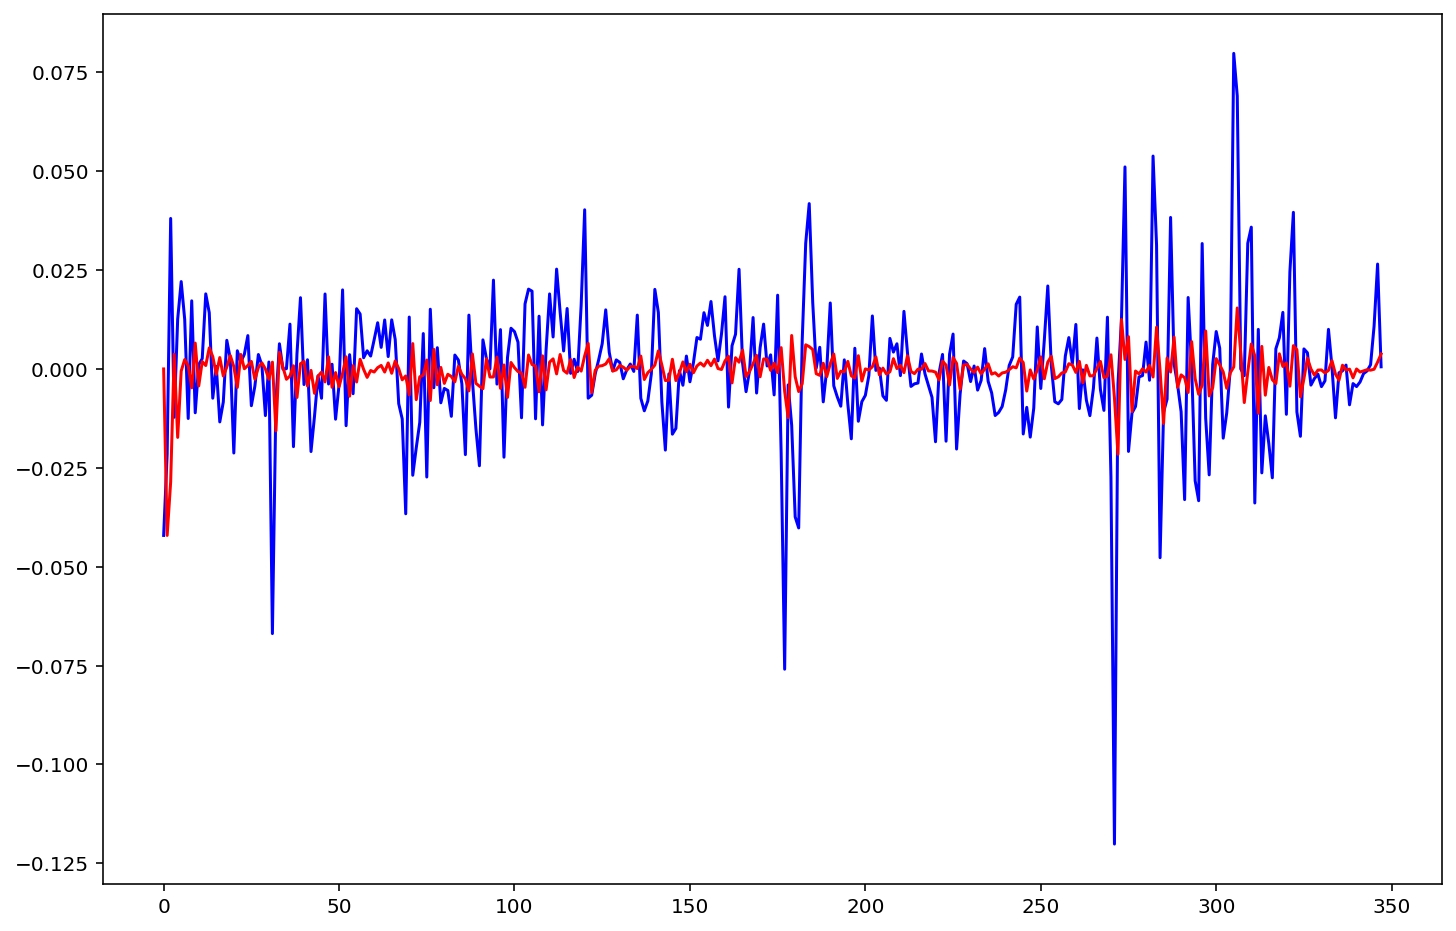

In [80]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

<Figure size 864x576 with 0 Axes>

IndexError: invalid index to scalar variable.

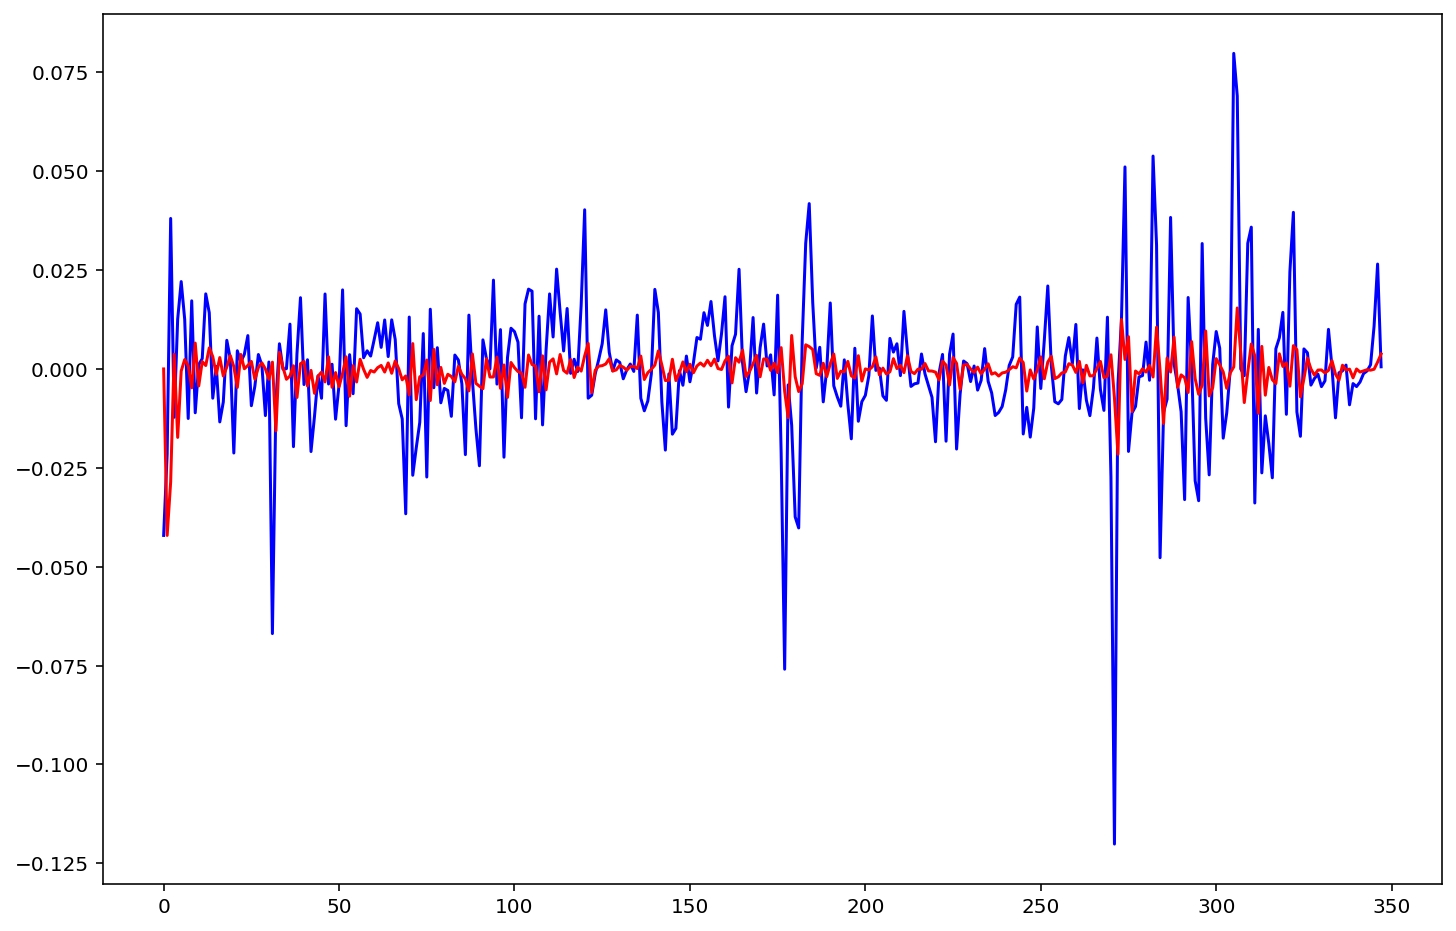

In [82]:
steps = 2

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()